In [79]:
%cd /home/transaction-generation

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from pathlib import Path
from ebes.pipeline.utils import optuna_df
from optuna.trial import TrialState
from glob import glob
from itertools import product
import warnings
import optuna
from optuna.exceptions import ExperimentalWarning 

warnings.filterwarnings("ignore", category=ExperimentalWarning)

/home/transaction-generation


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning:

using dhist requires you to install the `pickleshare` library.



In [80]:
def get_run(path, number, dataset, method, token_mode=False, rewrite=False):
    path = Path(f"log/generation/{path}/{number}")
    save_path = Path(f"configs/best_params/{dataset}")
    if token_mode:
        save_path /= "1to1"
    save_path.mkdir(parents=True, exist_ok=True)
    save_path = save_path / f"{method}.yaml"
    if not rewrite:
        if save_path.exists():
            print("Cant rewrite")
            return
    m_d = {
        "gru": "gru, 1to1",
        "gpt": "gpt, 1to1",
        "gru_dist": "oneshot/gru, methods/oneshot/dist, allto1",
        "gru_target": "oneshot/gru, methods/oneshot/target, allto1",
        "gru_matched": "oneshot/gru, methods/oneshot/matched, allto1",
        "vae": "vae",
    }
    config = (path / "params.txt").read_text()
    print_best_res(path)
    method_part = m_d.get(method, method)
    factory = f"config_factory: [start, metrics/default, datasets/{dataset}/{dataset}, methods/{method_part}]\n\n"
    config = factory + config
    save_path.write_text(config)

def print_best_res(path):
    df = pd.read_csv(path / "results.csv", index_col=0)["mean"]
    index = [id for id in df.index if "test" in id]
    df = df.loc[index]
    df.index = [id.replace("test_", "") for id in df.index]
    df.astype(str).replace('\\.', ',', regex=True).to_csv('res', sep='\t')


def prepare_data(path):
    path = Path(f"log/generation/{path}")
    df, study = optuna_df(path)
    col_to_drop = [
        "datetime_start",
        "datetime_complete",
        "system_attrs_fixed_params",
        "state",
        "value",
    ]
    col_params = ["value", "duration"] + [col for col in df if "params_" in col]
    col_user = ["value", "duration"] + [col for col in df if "user" in col]
    # df["duration"] = df["duration"].dt.total_seconds()
    return df, study, col_user, col_params


k = -1

In [135]:
datasets = ["alphabattle_small", "age"]
methods = ["vae", "detpp"]
token_modes = [False, True]
k += 1
full_product = list(product(datasets, methods, token_modes))
dataset, method, token_mode = full_product[k % len(full_product)]

path = f"{dataset}/{'1to1/optuna' if token_mode else 'optuna'}/{method}"
print(path)
df, study, col_user, col_params = prepare_data(path)

print(df.shape, df[~df["value"].isna()].shape)
test_cols = [col for col in col_user if ("mean" in col) and ("test" not in col)]
# test_cols = [col for col in test_cols if ("F1" in col) or ("Cardinality" in col)]
# par = [col for col in col_user + col_params if "BetaScheduler" in col]
# test_loss = "user_attrs_test_loss_mean"
sorted_df = df[~df["value"].isna()].sort_values("value")
best_run = sorted_df.iloc[-1].name
sorted_df[["value"] + test_cols][-10:]

age/optuna/detpp
(600, 76) (39, 76)


,value,user_attrs_Cardinality on small_group gen_mean,user_attrs_Cardinality on small_group orig_mean,user_attrs_F1_macro on small_group_mean,user_attrs_F1_micro on small_group_mean,user_attrs_OTD age_mean,user_attrs_OTD amount_rur_mean,user_attrs_OTD overall_mean,user_attrs_OTD small_group_mean,user_attrs_OTD trans_date_mean,...,user_attrs_memory_after_mean,user_attrs_train_Cardinality on small_group gen_mean,user_attrs_train_Cardinality on small_group orig_mean,user_attrs_train_F1_macro on small_group_mean,user_attrs_train_F1_micro on small_group_mean,user_attrs_train_OTD age_mean,user_attrs_train_OTD amount_rur_mean,user_attrs_train_OTD overall_mean,user_attrs_train_OTD small_group_mean,user_attrs_train_OTD trans_date_mean
323,-53.801930,8.308774,10.631,0.405302,0.708795,0.999990,0.501886,0.748714,0.674822,0.818158,...,75498.0,8.399194,10.666176,0.407851,0.710689,1.000000,0.486613,0.745172,0.675926,0.818148
521,-53.698955,8.255274,10.631,0.400350,0.705461,1.000000,0.500977,0.463982,0.667562,-0.312610,...,80354.0,8.321162,10.646079,0.403620,0.707142,1.000000,0.561095,0.525867,0.674020,-0.131647
303,-53.578084,8.529196,10.631,0.404306,0.706349,1.000000,0.486309,0.151069,0.671928,-1.553961,...,75162.0,8.587790,10.672615,0.408148,0.707208,1.000000,0.529509,0.256723,0.677398,-1.180015
424,-53.486892,8.261388,10.631,0.402818,0.703999,1.000000,0.500429,-0.709504,0.672357,-5.010804,...,76890.0,8.295102,10.689479,0.409122,0.708558,1.000000,0.478113,-0.665196,0.675826,-4.814724
305,-53.364592,8.342709,10.631,0.403381,0.707696,0.999981,0.499997,0.634588,0.670494,0.367879,...,76700.0,8.379765,10.683729,0.408057,0.709974,0.999998,0.498921,0.634302,0.675338,0.362950
243,-53.298817,8.000611,10.631,0.397070,0.702585,0.999981,0.495990,0.190168,0.668058,-1.403356,...,78128.0,8.085761,10.646630,0.401382,0.703337,0.999997,0.476326,0.195650,0.668932,-1.362656
199,-53.010165,8.394069,10.631,0.406199,0.707935,0.999971,0.501072,0.224866,0.674125,-1.275705,...,76688.0,8.421331,10.661187,0.410841,0.711587,0.999997,0.487718,0.276372,0.676450,-1.058677
215,-52.730473,8.385203,10.631,0.410277,0.711059,1.000000,0.500646,0.389893,0.675099,-0.616175,...,73318.0,8.447836,10.648889,0.416257,0.715189,1.000000,0.575573,0.467081,0.687685,-0.394935
536,-52.546022,8.359829,10.631,0.409988,0.711613,1.000000,0.500972,0.240056,0.677029,-1.217777,...,80024.0,8.419876,10.643984,0.417204,0.717088,1.000000,0.516609,0.180565,0.683572,-1.477919
282,-52.479327,8.320086,10.631,0.406463,0.708690,1.000000,0.502682,-0.548944,0.674918,-4.373376,...,77676.0,8.365977,10.691835,0.414831,0.716353,0.999998,0.595219,-0.024486,0.691734,-2.384896


In [101]:
get_run(path, 183, dataset, method, token_mode, True)


In [116]:
sorted_df[[col for col in col_user if ("memory" in col)]][-10:]

,user_attrs_memory_after_mean,user_attrs_memory_after_std
74,11054.0,0.0
50,15448.0,0.0
66,17772.0,0.0
49,18908.0,0.0
78,11762.0,0.0
42,17686.0,0.0
82,14168.0,0.0
81,11378.0,0.0
80,11174.0,0.0
84,12696.0,0.0


In [74]:
failed = df[(df["state"] != "COMPLETE") | (df[col_user].isna().any(axis=1))][col_user].index
print(failed)
for fail in df[(df["state"] != "COMPLETE") | (df[col_user].isna().any(axis=1))][col_user].index:
    error_path = Path(f"log/generation/{path}/{fail}/ERROR.txt")
    if error_path.exists():
        error = error_path.read_text()
        print(fail, error.split("\n")[-2])
    else:
        print(fail, df.loc[fail])

Index([  2,   4,   5,   7,  15,  16,  17,  18,  19,  20,
       ...
       289, 290, 298, 300, 301, 305, 306, 307, 308, 309],
      dtype='int64', length=185)
2 torch.cuda.OutOfMemoryError: CUDA out of memory. Tried to allocate 5.67 GiB. GPU 
4 torch.cuda.OutOfMemoryError: CUDA out of memory. Tried to allocate 5.46 GiB. GPU 
5 torch.cuda.OutOfMemoryError: CUDA out of memory. Tried to allocate 15.86 GiB. GPU 
7 torch.cuda.OutOfMemoryError: CUDA out of memory. Tried to allocate 6.64 GiB. GPU 
15 
16 
17 
18 
19 
20 
21 
22 
23 
24 
25 
26 
27 
28 
29 
30 
31 
32 
33 
34 
35 
36 
37 
38 
39 
40 
41 
42 
43 
44 
45 
46 
47 
48 
49 
50 
51 
52 
53 
54 
55 
56 
57 
58 
59 
60 
61 
62 
63 
64 
65 
66 
67 
68 
69 
70 
71 
72 
73 
74 
75 
76 
77 
78 
79 
80 
81 
82 
83 
84 
85 
86 
87 
88 
89 
90 
91 
92 
93 
94 
95 
96 
97 
98 
99 
120 torch.cuda.OutOfMemoryError: CUDA out of memory. Tried to allocate 5.41 GiB. GPU 
121 torch.cuda.OutOfMemoryError: CUDA out of memory. Tried to allocate 5.41 Gi

In [75]:
# optuna.visualization.plot_optimization_history(study)

### Params influence

In [76]:
trials = study.trials
trials = [trial for trial in trials if (trial.state == TrialState.COMPLETE) and (trial.value >= -1e4)]
plotted_trials = sorted(trials, key=lambda t: t.value)
study = optuna.create_study()

for trial in plotted_trials:
    study.add_trial(trial)

[I 2025-09-15 15:51:16,419] A new study created in memory with name: no-name-96dc0ed0-cf53-4294-9403-c8e78927d032


In [77]:
target = lambda t: (t.user_attrs["test_OTD overall_mean"])
target_name = "target"
fig = optuna.visualization.plot_param_importances(study, target=target, target_name=target_name)
print(fig._data[0]["x"][::-1])
print(fig._data[0]["y"][::-1])
take = 7
params = fig._data[0]["y"][-take:]
not_imp = list(set([col.replace("params_", "") for col in col_params]) - set(params) - {"duration", "value", "system_attrs_fixed_params"})
fig

[0.5898733240869858, 0.16537854782255595, 0.1296331387829132, 0.04447632621437558, 0.025722607503003078, 0.024558496166869344, 0.013944047213503652, 0.003978982610401779, 0.0016673888528389604, 0.0007671407465527272]
['optimizer.params.lr', 'optimizer.params.weight_decay', 'model.autoencoder.params.num_emb_dim', 'model.params.k_factor', 'model.latent_encoder.params.num_layers', 'model.autoencoder.params.num_norm', 'model.latent_encoder.params.dropout', 'model.autoencoder.params.cat_emb_dim', 'model.latent_encoder.params.hidden_size', 'loss.params.matching_weights._presence']


In [52]:
params

['optimizer.params.lr',
 'model.params.k_factor',
 'model.latent_encoder.params.num_layers',
 'model.autoencoder.params.cat_emb_dim',
 'model.autoencoder.params.num_emb_dim',
 'loss.params.matching_weights._presence',
 'model.latent_encoder.params.hidden_size']

In [78]:
# fig = optuna.visualization.plot_parallel_coordinate(plotted_study, target=target, target_name=target_name, params=['model.encoder.params.pooling', 'pretrain_model.encoder.params.pooling',])
# fig = optuna.visualization.plot_contour(study, target=target, target_name=target_name, params=params+not_imp)
fig = optuna.visualization.plot_slice(study, target=target, target_name=target_name)#, params=["model.encoder.params.num_layers"] )
# fig = optuna.visualization.plot_optimization_history(study, target=target, target_name=target_name, error_bar=False)
# targets = lambda t: (t.params["schedulers.beta.BetaScheduler.factor"], t.user_attrs["test_Reconstruction overall_mean"])
# target_names = ["memory_after_mean", "test_Reconstruction overall_mean"]
# fig = optuna.visualization.plot_pareto_front(study, targets=targets, target_names=target_names)
fig

In [48]:
pareto_targets = lambda t: (t.user_attrs["test_loss_mean"], t.user_attrs["test_kl_loss_mean"])
optuna.visualization.plot_pareto_front(study, targets=pareto_targets, target_names=["loss", "kl_loss"])


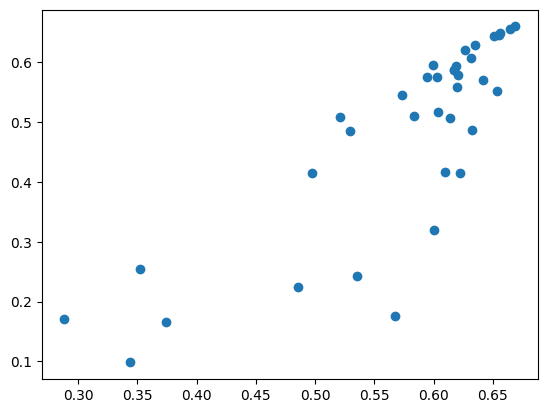

In [21]:
df[col_user]
# user_attrs_Reconstruction overall_mean
# user_attrs_test_Reconstruction overall_mean  
corr = df.loc[:, ["user_attrs_Reconstruction overall_mean", "user_attrs_test_Reconstruction overall_mean"]].values
corr = corr[corr[:, 1] > 0.]
corr = corr.T
plt.scatter(corr[0], corr[1])

In [14]:
corr[1]

array([ 2.24765981e-01,  5.58193365e-01,  5.79441426e-01, -2.52478756e+01,
       -1.83249119e+00,  5.93541510e-01, -6.89742099e+01,  6.20540413e-01,
        5.51473175e-01,  5.75338017e-01,  5.87397511e-01,  5.06810327e-01,
        4.14948080e-01,  6.56091304e-01, -2.29449604e+02,  6.59978799e-01,
        5.95479827e-01,  6.08065133e-01,  6.28701189e-01,  3.19842927e-01,
        6.48585040e-01,  5.70997809e-01,  4.16447689e-01, -2.43559946e+01,
       -1.92204170e-01,  4.85782606e-01,  1.76263074e-01,  2.43228096e-01,
        4.86158230e-01,  5.44850264e-01,  5.08651126e-01,  6.44586897e-01,
        6.46302449e-01,  5.16191953e-01,  5.87891203e-01,  4.15233483e-01,
        5.76327024e-01,  5.09958578e-01])

In [20]:
df.columns

Index(['value', 'datetime_start', 'datetime_complete', 'duration',
       'params_model.encoder.params.dropout',
       'params_model.encoder.params.hidden_size',
       'params_model.encoder.params.num_layers',
       'params_model.preprocessor.batch_transforms.0.TimeToFeatures.process_type',
       'params_model.preprocessor.cat_emb_dim',
       'params_model.preprocessor.num_emb_dim',
       'params_model.preprocessor.num_norm', 'params_optimizer.params.lr',
       'params_optimizer.params.weight_decay',
       'user_attrs_Reconstruction amount_mean',
       'user_attrs_Reconstruction amount_std',
       'user_attrs_Reconstruction currency_mean',
       'user_attrs_Reconstruction currency_std',
       'user_attrs_Reconstruction days_since_first_tx_mean',
       'user_attrs_Reconstruction days_since_first_tx_std',
       'user_attrs_Reconstruction dst_type11_mean',
       'user_attrs_Reconstruction dst_type11_std',
       'user_attrs_Reconstruction dst_type12_mean',
       'user_attr